# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Import training and test data

In [2]:
train_data = pd.read_csv('movement_data/fingerprinting_data/train.csv')
test_data = pd.read_csv('movement_data/fingerprinting_data/test.csv')

# Prepare data for model training and validation

In [3]:
def normalise_impute_input(input_features):
    """
    This function normalises the RSSI values into values that fall between 0 and 1.
    Any missing values will be imputed with the maximum value of 1.
    """
    input_features = np.abs(input_features)  # ensure that all rssi values are positive
    num_features = len(input_features[0,:])
    max_value = np.zeros(num_features)
    min_value = np.zeros(num_features)

    for i in range(num_features):
        min_value[i] = np.nanmin(input_features[:,i])
        max_value[i] = np.nanmax(input_features[:,i])
        input_features[:,i] = (input_features[:,i] - min_value[i]) / (max_value[i] - min_value[i] + 1e-6)
    
    input_features[np.isnan(input_features)] = 1.0
        
    return input_features

In [4]:
def prepare_data(data):
    """
    This function splits the data into input features and labels and returns them as outputs.
    """
    data = data.sample(frac=1).reset_index(drop=True)  # shuffle the data
    
    X = data.loc[:,'RSSI_AssemblyEntrance':'RSSI_Printer'].values
    X = normalise_impute_input(X)
    Y = data.loc[:,'Model1':'Model3_Printer']
    
    return X, Y

In [5]:
# Preparing train, test data for ensemble classification
Xtrain, Ytrain = prepare_data(train_data)
Xtest, Ytest = prepare_data(test_data)

# Model training and hyperparameter tuning via random cross validation

In [6]:
def hyperparameter_tuning(Xtrain, Ytrain):
    """
    This function performs hyperparmeter tuning using a 5-fold cross validation approach, based
    on the training dataset and returns the optimised model.
    """
    param_grid = {'n_estimators': np.arange(50, 201, 10),
                  'min_samples_leaf': np.arange(1,6),
                  'min_samples_split': np.arange(2,6),
                  'max_depth': np.arange(2,6)}

    random_cv = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, n_iter=100, 
                                   cv=5, verbose=2, scoring='f1_macro', n_jobs=-1)
    random_cv.fit(Xtrain, Ytrain)
    
    print('Best Model Parameters')
    print(random_cv.best_params_)
    
    return random_cv.best_estimator_

In [7]:
def balance_training_data(training_data):
    """
    This function splits up the training data into equal sizes such that each subdataset 
    has identical number of positive and negative classes. This is used to deal with
    the class imbalance issue in the training data.
    """
    positive_class = training_data[training_data['label'] == 1]
    num_positive = len(positive_class)
    negative_class = training_data[training_data['label'] == 0]
    num_negative = len(negative_class)
    num_batch = int(num_negative / num_positive)
    batch_size = int(num_negative / num_batch)
    
    training_list = []
    for i in range(num_batch):
        training_batch = negative_class.loc[i*batch_size:(i+1)*batch_size,:]
        training_batch = pd.concat([training_batch, positive_class], ignore_index=True, sort=False)
        training_batch = training_batch.sample(frac=1).reset_index(drop=True)
        training_list.append((training_batch.values[:,:-1], training_batch['label']))
        
    return training_list

In [8]:
def train_ensemble_model(Xtrain, Ytrain):
    """
    This function trains an ensemble model by spliting up the training data into
    equal sizes such that the number of positive and negative classes are identical
    in each sub-datasets.
    """
    training_data = pd.DataFrame(Xtrain)
    training_data['label'] = Ytrain
    training_list = balance_training_data(training_data)
    
    model_list = []
    for input_features, label in training_list:
        model_list.append(hyperparameter_tuning(input_features, label))
        
    return model_list

In [9]:
# Optimise assembly space model
assemblyspace_model = train_ensemble_model(Xtrain, Ytrain['Model3_AssemblySpace'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.8s finished


Best Model Parameters
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.0s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.0s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.4s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.3s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 383 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.0s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.6s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.7s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.4s finished


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.8s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.0s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.8s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.6s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.9s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.3s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2}


In [10]:
# Optimise prototyping room model
prototyping_model = train_ensemble_model(Xtrain, Ytrain['Model3_PrototypingRoom'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.5s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.7s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.1s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.6s finished


Best Model Parameters
{'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   46.0s finished


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   46.9s finished


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   48.5s finished


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.1s finished


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.0s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   53.9s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.8s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.1s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.4s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   46.2s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.6s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 4}


In [11]:
# Optimise out model
out_model = train_ensemble_model(Xtrain, Ytrain['Model3_Out'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.6s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.7s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.2s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.3s


Best Model Parameters
{'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.7s finished


In [12]:
# Optimise laser cutting room model
lasercutting_model = train_ensemble_model(Xtrain, Ytrain['Model3_LaserCuttingRoom'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.4min finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4}


In [13]:
# Optimise precision room model
precision_model = train_ensemble_model(Xtrain, Ytrain['Model3_PrecisionRoom'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.6s finished


Best Model Parameters
{'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.1s finished


Best Model Parameters
{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.4s finished


Best Model Parameters
{'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.1s finished


Best Model Parameters
{'n_estimators': 90, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.0s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   55.2s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.8s finished


Best Model Parameters
{'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.4s finished


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.7s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   53.1s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.7s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.1s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.3s finished


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}


In [14]:
# Optimise pantry other model
pantry_other_model = train_ensemble_model(Xtrain, Ytrain['Model3_Pantry_Other'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.7s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.7s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   55.0s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.8s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.5s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   55.0s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.0min finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.2s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   53.3s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.5s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   59.4s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.9s finished


Best Model Parameters
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.0s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   53.0s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4}


In [15]:
# Optimise fridge and coffeemachine model
fridgecoffeemachine_model = train_ensemble_model(Xtrain, Ytrain['Model3_FridgeCoffeeMachine'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.5s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   53.3s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.6s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   56.9s finished


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.9s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.6s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   50.4s finished


Best Model Parameters
{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.7s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   52.2s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.2s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   56.3s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   51.9s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   56.0s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   49.9s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5}


In [16]:
# Optimise microwave waterdispenser model
microwavewaterdispenser_model = train_ensemble_model(Xtrain, Ytrain['Model3_MicrowaveWaterDispenser'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.9s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 375 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.5s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.2s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.0s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.6s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.2s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 379 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.0s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.7s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.6s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.9s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.0s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.4s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.1s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.1s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.7s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}


In [17]:
# Optimise meeting room model
meeting_model = train_ensemble_model(Xtrain, Ytrain['Model3_MeetingRoom'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.0min finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.6s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   59.5s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 2}


In [18]:
# Optimise office area 1 model
officearea_1_model = train_ensemble_model(Xtrain, Ytrain['Model3_OfficeArea_1'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4}


In [19]:
# Optimise office area 2 model
officearea_2_model = train_ensemble_model(Xtrain, Ytrain['Model3_OfficeArea_2'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 4}


In [20]:
# Optimise printer model
printer_model = train_ensemble_model(Xtrain, Ytrain['Model3_Printer'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 371 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.4s finished


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   37.9s finished


Best Model Parameters
{'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.1s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.4s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.5s finished


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.8s finished


Best Model Parameters
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.6s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.2s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   43.3s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.2s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.7s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.7s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.5s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 379 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.8s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.8s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.3s finished


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 4}


# Calculate test performance of ensemble model

In [21]:
def plot_model_performance(true_label, prediction):
    """
    This function compares the predicted location with the true location information
    and presents the model performance using a classification report and a confusion
    matrix.
    """   
    # Classification report
    print(classification_report(true_label, prediction))
    
    # Confusion matrix in the form of a heat map
    cm = confusion_matrix(true_label, prediction)
    cm = pd.DataFrame(cm)
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [22]:
def predict(ensemble_model, Xtest):
    """
    This function calculates the prediction probability of 
    each individual model in the ensemble model and finds the
    average prediction probability.
    """
    prediction_proba = np.zeros((Xtest.shape[0],1))
    for model in ensemble_model:
        prediction_proba += model.predict_proba(Xtest)[:,1].reshape(-1,1) / len(ensemble_model)
        
    return prediction_proba

In [24]:
# Extract the prediction probability based on each individual zone model
assemblyspace_prediction = predict(assemblyspace_model, Xtest)
prototyping_prediction = predict(prototyping_model, Xtest)
out_prediction = predict(out_model, Xtest)
lasercutting_prediction = predict(lasercutting_model, Xtest)
precision_prediction = predict(precision_model, Xtest)
pantry_other_prediction = predict(pantry_other_model, Xtest)
fridgecoffeemachine_prediction = predict(fridgecoffeemachine_model, Xtest)
microwavewaterdispenser_prediction = predict(microwavewaterdispenser_model, Xtest)
meeting_prediction = predict(meeting_model, Xtest)
officearea_1_prediction = predict(officearea_1_model, Xtest)
officearea_2_prediction = predict(officearea_2_model, Xtest)
printer_prediction = predict(printer_model, Xtest)

In [25]:
# Identify the most likely (confident) prediction among all the models
prediction = np.hstack((assemblyspace_prediction,
                        prototyping_prediction,
                        out_prediction,
                        lasercutting_prediction,
                        precision_prediction,
                        pantry_other_prediction,
                        fridgecoffeemachine_prediction,
                        microwavewaterdispenser_prediction,
                        meeting_prediction,
                        officearea_1_prediction,
                        officearea_2_prediction,
                        printer_prediction))

columns = ['AssemblySpace','PrototypingRoom','Out','LaserCuttingRoom',
            'PrecisionRoom','Pantry_Other','Pantry_FridgeCoffeeMachine',
            'Pantry_MicrowaveWaterDispenser','MeetingRoom',
            'OfficeArea_1','OfficeArea_2','Printer']
prediction = pd.DataFrame(prediction, columns=columns)
final_prediction = prediction.idxmax(axis=1)

                                precision    recall  f1-score   support

                 AssemblySpace       0.73      1.00      0.84       210
              LaserCuttingRoom       0.89      0.90      0.90       898
                   MeetingRoom       0.91      0.55      0.69       279
                  OfficeArea_1       0.94      0.81      0.87       911
                  OfficeArea_2       0.89      0.96      0.92      1213
                           Out       0.99      1.00      0.99       154
    Pantry_FridgeCoffeeMachine       0.38      0.91      0.54       272
Pantry_MicrowaveWaterDispenser       0.79      0.35      0.49       251
                  Pantry_Other       0.31      0.07      0.12       254
                 PrecisionRoom       0.99      0.75      0.85       262
                       Printer       0.77      0.81      0.79       146
               PrototypingRoom       0.64      0.83      0.72       214

                      accuracy                           0.81 

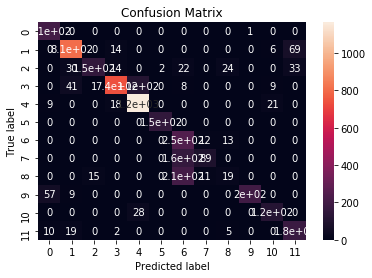

In [26]:
plot_model_performance(Ytest['Model1'], final_prediction)

# Identify significant factors using feature importance scores

In [27]:
def combine_importance_score(model_list):
    """
    This function combines the feature importance score of each individual model by
    calculating the average importance score of each input feature in the ensemble model.
    """
    score = np.zeros(len(model_list[0].feature_importances_))
    for model in model_list:
        score += model.feature_importances_ / float(len(model_list))
        
    return score

In [28]:
def plot_feature_importance(model_list, input_columns):
    """
    This function calculates the feature importance score of each input feature and plots
    them on a pareto chart in descending order.
    """
    cutoff = 1

    score = combine_importance_score(model_list)
    feature_importance = pd.DataFrame(score)
    x_axis = input_columns
    feature_importance.index = x_axis
    feature_importance.columns = ['Feature Importance Score']
    feature_importance.sort_values(by='Feature Importance Score',axis=0,ascending=False, inplace=True)

    pareto_score = []
    total_score = sum(feature_importance['Feature Importance Score'])
    cumulative_score = 0
    for index in feature_importance.index:
        cumulative_score += feature_importance.loc[index,'Feature Importance Score']
        if cumulative_score <= cutoff:
            pareto_score.append(cumulative_score/total_score * 100)
        else:
            break

    feature_importance_cutoff_index = feature_importance.index[:len(pareto_score)]
    print(feature_importance_cutoff_index)
    feature_importance_cutoff = feature_importance.loc[feature_importance_cutoff_index[0]:feature_importance_cutoff_index[len(pareto_score)-1],:]

    fig, ax = plt.subplots()
    fig = plt.xticks(rotation=90)
    fig = sns.barplot(x=feature_importance_cutoff.index,y=feature_importance_cutoff['Feature Importance Score'], ax=ax)
    ax2 = ax.twinx()
    ax2.set_ylabel("Cumulative % of Total Importance Score")
    fig = sns.lineplot(x=np.arange(len(feature_importance_cutoff)), y=pareto_score, ax=ax2, color='black')

Index(['RSSI_Workshop', 'RSSI_Fridge', 'RSSI_MeetingRoom',
       'RSSI_CoffeeMachine', 'RSSI_ResearcherEntrance', 'RSSI_Microwave',
       'RSSI_Stratasys', 'RSSI_WaterDispenser', 'RSSI_PrototypingEntrance',
       'RSSI_LabManagerOffice', 'RSSI_Ada', 'RSSI_AssemblyEntrance',
       'RSSI_PrototypingRoom', 'RSSI_AssemblySpace',
       'RSSI_LaserCuttingEntrance', 'RSSI_Carlye', 'RSSI_3DPrinter',
       'RSSI_PrecisionRoom', 'RSSI_PrecisionEntrance', 'RSSI_LaserCutter',
       'RSSI_Printer'],
      dtype='object')


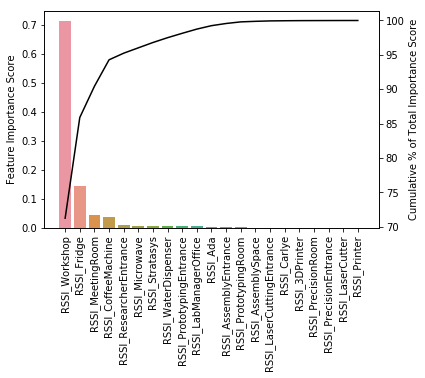

In [176]:
# Identify significant factors for assembly space model
input_columns = train_data.loc[:,'RSSI_AssemblyEntrance':'RSSI_Printer'].columns.values.tolist()
plot_feature_importance(assemblyspace_model, input_columns)
assemblyspace_features = ['RSSI_Workshop','RSSI_Fridge','RSSI_MeetingRoom','RSSI_CoffeeMachine',
                          'RSSI_ResearcherEntrance','RSSI_Microwave','RSSI_Stratasys']
assemblyspace_feature_index = [input_columns.index(feature) for feature in assemblyspace_features]

Index(['RSSI_PrototypingRoom', 'RSSI_PrecisionEntrance', 'RSSI_Workshop',
       'RSSI_Microwave', 'RSSI_AssemblySpace', 'RSSI_CoffeeMachine',
       'RSSI_Carlye', 'RSSI_Fridge', 'RSSI_WaterDispenser', 'RSSI_Printer',
       'RSSI_Stratasys', 'RSSI_PrototypingEntrance', 'RSSI_ResearcherEntrance',
       'RSSI_AssemblyEntrance', 'RSSI_3DPrinter', 'RSSI_PrecisionRoom',
       'RSSI_MeetingRoom', 'RSSI_Ada', 'RSSI_LabManagerOffice',
       'RSSI_LaserCutter', 'RSSI_LaserCuttingEntrance'],
      dtype='object')


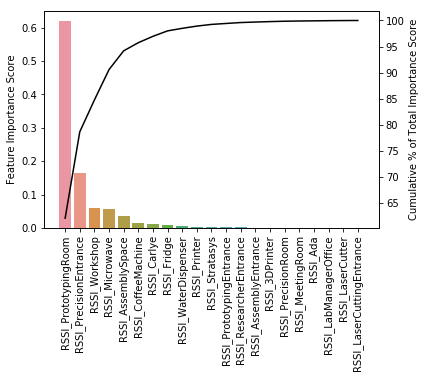

In [177]:
# Identify significant factors for prototyping room model
plot_feature_importance(prototyping_model, input_columns)
prototyping_features = ['RSSI_PrototypingRoom','RSSI_PrecisionEntrance','RSSI_Workshop','RSSI_Microwave',
                        'RSSI_AssemblySpace','RSSI_CoffeeMachine','RSSI_Carlye','RSSI_Fridge']
prototyping_feature_index = [input_columns.index(feature) for feature in prototyping_features]

Index(['RSSI_ResearcherEntrance', 'RSSI_LaserCuttingEntrance', 'RSSI_Printer',
       'RSSI_PrecisionRoom', 'RSSI_3DPrinter', 'RSSI_PrecisionEntrance',
       'RSSI_CoffeeMachine', 'RSSI_AssemblySpace', 'RSSI_MeetingRoom',
       'RSSI_WaterDispenser', 'RSSI_Microwave', 'RSSI_Fridge', 'RSSI_Carlye',
       'RSSI_Ada', 'RSSI_LabManagerOffice', 'RSSI_LaserCutter',
       'RSSI_PrototypingRoom', 'RSSI_Workshop', 'RSSI_Stratasys',
       'RSSI_PrototypingEntrance', 'RSSI_AssemblyEntrance'],
      dtype='object')


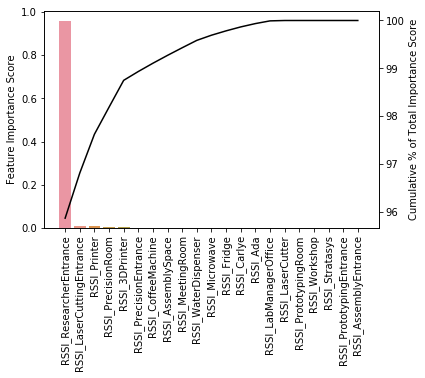

In [222]:
# Identify significant factors for out model
plot_feature_importance(out_model, input_columns)
out_features = ['RSSI_ResearcherEntrance','RSSI_LaserCuttingEntrance','RSSI_Printer',
                'RSSI_PrecisionRoom','RSSI_3DPrinter','RSSI_PrecisionEntrance']
out_feature_index = [input_columns.index(feature) for feature in out_features]

Index(['RSSI_LaserCuttingEntrance', 'RSSI_LaserCutter', 'RSSI_Stratasys',
       'RSSI_3DPrinter', 'RSSI_ResearcherEntrance', 'RSSI_AssemblyEntrance',
       'RSSI_LabManagerOffice', 'RSSI_Printer', 'RSSI_PrototypingEntrance',
       'RSSI_PrecisionEntrance', 'RSSI_Ada', 'RSSI_Carlye',
       'RSSI_WaterDispenser', 'RSSI_Microwave', 'RSSI_MeetingRoom',
       'RSSI_CoffeeMachine', 'RSSI_PrecisionRoom', 'RSSI_Fridge',
       'RSSI_AssemblySpace', 'RSSI_PrototypingRoom', 'RSSI_Workshop'],
      dtype='object')


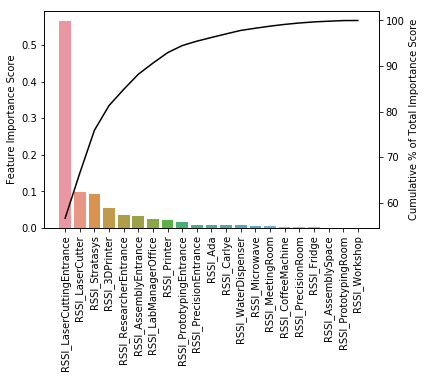

In [179]:
# Identify significant factors for lasercutting room model
plot_feature_importance(lasercutting_model, input_columns)
lasercutting_features = ['RSSI_LaserCuttingEntrance','RSSI_LaserCutter','RSSI_Stratasys','RSSI_3DPrinter',
                         'RSSI_ResearcherEntrance','RSSI_AssemblyEntrance','RSSI_LabManagerOffice']
lasercutting_feature_index = [input_columns.index(feature) for feature in lasercutting_features]

Index(['RSSI_Microwave', 'RSSI_Workshop', 'RSSI_Stratasys',
       'RSSI_PrototypingEntrance', 'RSSI_Carlye', 'RSSI_WaterDispenser',
       'RSSI_MeetingRoom', 'RSSI_3DPrinter', 'RSSI_Printer', 'RSSI_Fridge',
       'RSSI_CoffeeMachine', 'RSSI_LaserCutter', 'RSSI_PrecisionRoom',
       'RSSI_AssemblySpace', 'RSSI_LabManagerOffice', 'RSSI_Ada',
       'RSSI_PrecisionEntrance', 'RSSI_PrototypingRoom',
       'RSSI_AssemblyEntrance', 'RSSI_ResearcherEntrance'],
      dtype='object')


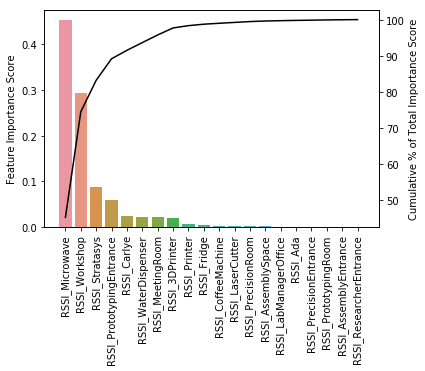

In [241]:
# Identify significant factors for precision model
plot_feature_importance(precision_model, input_columns)
precision_features = ['RSSI_Microwave','RSSI_Workshop','RSSI_Stratasys','RSSI_PrototypingEntrance',
                      'RSSI_Carlye','RSSI_WaterDispenser','RSSI_MeetingRoom','RSSI_3DPrinter',
                      'RSSI_Printer','RSSI_Fridge','RSSI_CoffeeMachine','RSSI_LaserCutter',
                      'RSSI_PrecisionRoom','RSSI_AssemblySpace','RSSI_LabManagerOffice']
precision_feature_index = [input_columns.index(feature) for feature in precision_features]

Index(['RSSI_AssemblySpace', 'RSSI_Fridge', 'RSSI_Stratasys',
       'RSSI_PrecisionRoom', 'RSSI_Workshop', 'RSSI_PrototypingEntrance',
       'RSSI_3DPrinter', 'RSSI_Microwave', 'RSSI_MeetingRoom',
       'RSSI_WaterDispenser', 'RSSI_PrototypingRoom', 'RSSI_LaserCutter',
       'RSSI_CoffeeMachine', 'RSSI_Ada', 'RSSI_PrecisionEntrance',
       'RSSI_Carlye', 'RSSI_LabManagerOffice', 'RSSI_ResearcherEntrance',
       'RSSI_LaserCuttingEntrance', 'RSSI_Printer'],
      dtype='object')


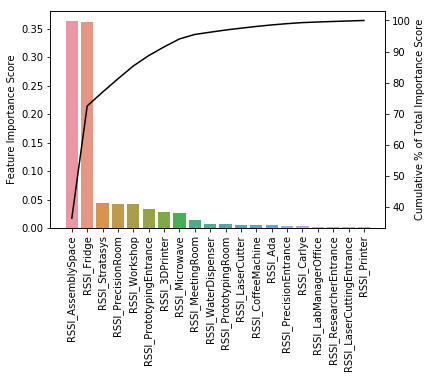

In [242]:
# Identify significant factors for pantry_other model
plot_feature_importance(pantry_other_model, input_columns)
pantry_other_features = ['RSSI_AssemblySpace','RSSI_Fridge','RSSI_Stratasys','RSSI_PrecisionRoom',
                         'RSSI_Workshop','RSSI_PrototypingEntrance','RSSI_3DPrinter','RSSI_Microwave',
                         'RSSI_MeetingRoom']
pantry_other_feature_index = [input_columns.index(feature) for feature in pantry_other_features]

Index(['RSSI_LabManagerOffice', 'RSSI_CoffeeMachine', 'RSSI_WaterDispenser',
       'RSSI_PrecisionEntrance', 'RSSI_Microwave', 'RSSI_Fridge',
       'RSSI_PrecisionRoom', 'RSSI_Workshop', 'RSSI_ResearcherEntrance',
       'RSSI_Ada', 'RSSI_PrototypingRoom', 'RSSI_LaserCuttingEntrance',
       'RSSI_PrototypingEntrance', 'RSSI_MeetingRoom', 'RSSI_3DPrinter',
       'RSSI_Carlye', 'RSSI_LaserCutter', 'RSSI_AssemblySpace',
       'RSSI_Stratasys', 'RSSI_Printer', 'RSSI_AssemblyEntrance'],
      dtype='object')


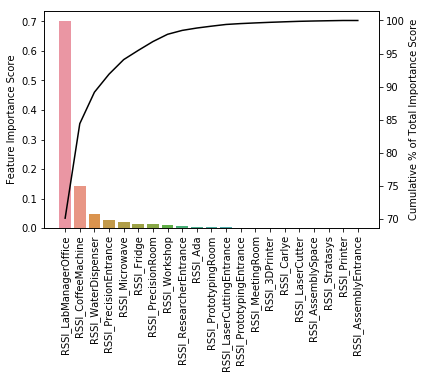

In [225]:
# Identify significant factors for fridge + coffeemachine model
plot_feature_importance(fridgecoffeemachine_model, input_columns)
fridgecoffeemachine_features = ['RSSI_LabManagerOffice','RSSI_CoffeeMachine','RSSI_WaterDispenser',
                                'RSSI_PrecisionEntrance','RSSI_Microwave','RSSI_Fridge','RSSI_PrecisionRoom',
                                'RSSI_Workshop','RSSI_ResearcherEntrance','RSSI_Ada','RSSI_PrototypingRoom',
                                'RSSI_LaserCuttingEntrance','RSSI_PrototypingEntrance','RSSI_MeetingRoom']
fridgecoffeemachine_feature_index = [input_columns.index(feature) for feature in fridgecoffeemachine_features]

Index(['RSSI_PrecisionRoom', 'RSSI_WaterDispenser', 'RSSI_Microwave',
       'RSSI_Stratasys', 'RSSI_Ada', 'RSSI_ResearcherEntrance',
       'RSSI_3DPrinter', 'RSSI_Fridge', 'RSSI_LaserCuttingEntrance',
       'RSSI_CoffeeMachine', 'RSSI_MeetingRoom', 'RSSI_PrototypingRoom',
       'RSSI_LabManagerOffice', 'RSSI_Printer', 'RSSI_Workshop', 'RSSI_Carlye',
       'RSSI_PrecisionEntrance', 'RSSI_PrototypingEntrance',
       'RSSI_LaserCutter', 'RSSI_AssemblySpace', 'RSSI_AssemblyEntrance'],
      dtype='object')


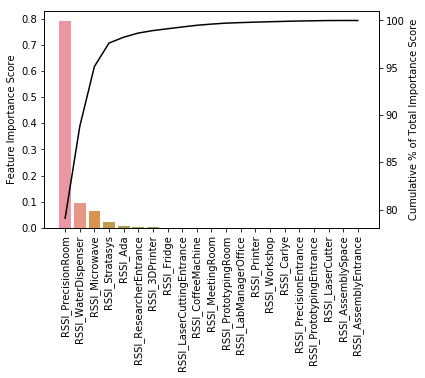

In [226]:
# Identify significant factors for microwave + waterdispenser model
plot_feature_importance(microwavewaterdispenser_model, input_columns)
microwavewaterdispenser_features = ['RSSI_PrecisionRoom','RSSI_WaterDispenser',
                                    'RSSI_Microwave','RSSI_Stratasys','RSSI_Ada',
                                    'RSSI_ResearcherEntrance','RSSI_3DPrinter']
microwavewaterdispenser_feature_index = [input_columns.index(feature) for feature in microwavewaterdispenser_features]

Index(['RSSI_WaterDispenser', 'RSSI_AssemblySpace', 'RSSI_Stratasys',
       'RSSI_LabManagerOffice', 'RSSI_Fridge', 'RSSI_CoffeeMachine',
       'RSSI_3DPrinter', 'RSSI_LaserCutter', 'RSSI_MeetingRoom',
       'RSSI_AssemblyEntrance', 'RSSI_Microwave', 'RSSI_PrecisionEntrance',
       'RSSI_PrototypingRoom', 'RSSI_PrototypingEntrance',
       'RSSI_PrecisionRoom', 'RSSI_Printer', 'RSSI_Workshop',
       'RSSI_LaserCuttingEntrance', 'RSSI_ResearcherEntrance', 'RSSI_Ada',
       'RSSI_Carlye'],
      dtype='object')


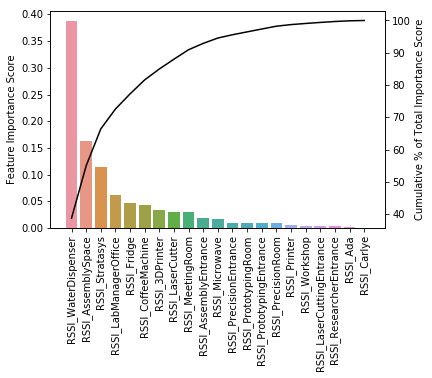

In [254]:
# Identify significant factors for meeting model
plot_feature_importance(meeting_model, input_columns)
meeting_features = ['RSSI_WaterDispenser','RSSI_AssemblySpace','RSSI_Stratasys','RSSI_LabManagerOffice',
                    'RSSI_Fridge','RSSI_CoffeeMachine','RSSI_3DPrinter','RSSI_LaserCutter','RSSI_MeetingRoom',
                    'RSSI_AssemblyEntrance','RSSI_Microwave','RSSI_PrecisionEntrance','RSSI_PrototypingRoom',
                    'RSSI_PrototypingEntrance']
meeting_feature_index = [input_columns.index(feature) for feature in meeting_features]

Index(['RSSI_Ada', 'RSSI_PrecisionEntrance', 'RSSI_Fridge',
       'RSSI_AssemblyEntrance', 'RSSI_3DPrinter', 'RSSI_Stratasys',
       'RSSI_ResearcherEntrance', 'RSSI_CoffeeMachine',
       'RSSI_LabManagerOffice', 'RSSI_Printer', 'RSSI_PrototypingEntrance',
       'RSSI_LaserCuttingEntrance', 'RSSI_MeetingRoom', 'RSSI_Carlye',
       'RSSI_AssemblySpace', 'RSSI_Workshop', 'RSSI_LaserCutter',
       'RSSI_PrototypingRoom', 'RSSI_PrecisionRoom', 'RSSI_Microwave',
       'RSSI_WaterDispenser'],
      dtype='object')


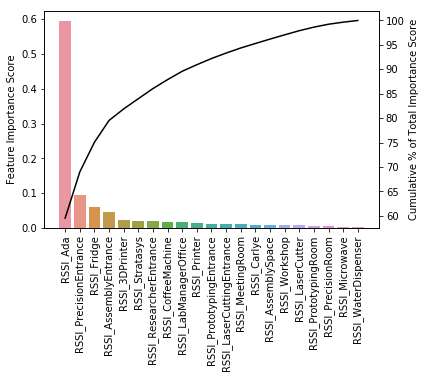

In [185]:
# Identify significant factors for officearea_1 model
plot_feature_importance(officearea_1_model, input_columns)
officearea_1_features = ['RSSI_Ada','RSSI_PrecisionEntrance','RSSI_Fridge','RSSI_AssemblyEntrance',
                         'RSSI_3DPrinter','RSSI_Stratasys','RSSI_ResearcherEntrance',
                         'RSSI_CoffeeMachine','RSSI_LabManagerOffice']
officearea_1_feature_index = [input_columns.index(feature) for feature in officearea_1_features]

Index(['RSSI_Stratasys', 'RSSI_LabManagerOffice', 'RSSI_PrecisionEntrance',
       'RSSI_Ada', 'RSSI_PrecisionRoom', 'RSSI_Carlye', 'RSSI_Printer',
       'RSSI_CoffeeMachine', 'RSSI_PrototypingEntrance', 'RSSI_MeetingRoom',
       'RSSI_Workshop', 'RSSI_PrototypingRoom', 'RSSI_Fridge',
       'RSSI_3DPrinter', 'RSSI_LaserCuttingEntrance', 'RSSI_AssemblySpace',
       'RSSI_WaterDispenser', 'RSSI_LaserCutter', 'RSSI_ResearcherEntrance',
       'RSSI_Microwave', 'RSSI_AssemblyEntrance'],
      dtype='object')


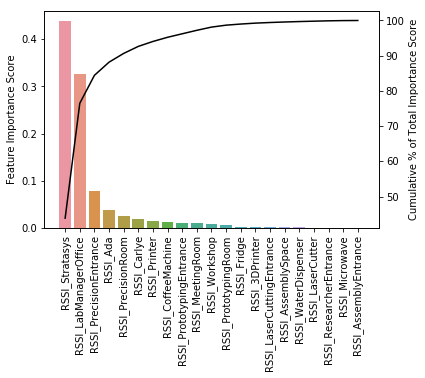

In [244]:
# Identify significant factors for officearea_2 model
plot_feature_importance(officearea_2_model, input_columns)
officearea_2_features = ['RSSI_Stratasys','RSSI_LabManagerOffice','RSSI_PrecisionEntrance',
                         'RSSI_Ada','RSSI_PrecisionRoom','RSSI_Carlye','RSSI_Printer']
officearea_2_feature_index = [input_columns.index(feature) for feature in officearea_2_features]

Index(['RSSI_Printer', 'RSSI_WaterDispenser', 'RSSI_Stratasys', 'RSSI_Ada',
       'RSSI_3DPrinter', 'RSSI_Workshop', 'RSSI_AssemblySpace',
       'RSSI_LabManagerOffice', 'RSSI_PrototypingEntrance',
       'RSSI_PrecisionEntrance', 'RSSI_Carlye', 'RSSI_PrototypingRoom',
       'RSSI_Fridge', 'RSSI_ResearcherEntrance', 'RSSI_LaserCuttingEntrance',
       'RSSI_CoffeeMachine', 'RSSI_MeetingRoom', 'RSSI_LaserCutter',
       'RSSI_PrecisionRoom', 'RSSI_Microwave', 'RSSI_AssemblyEntrance'],
      dtype='object')


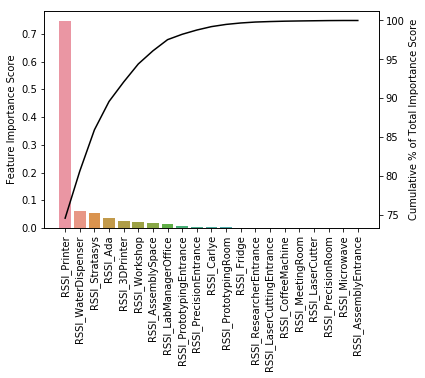

In [245]:
# Identify significant factors for printer model
plot_feature_importance(printer_model, input_columns)
printer_features = ['RSSI_Printer','RSSI_WaterDispenser','RSSI_Stratasys','RSSI_Ada',
                    'RSSI_3DPrinter','RSSI_Workshop','RSSI_AssemblySpace', 
                    'RSSI_LabManagerOffice','RSSI_PrototypingEntrance','RSSI_PrecisionEntrance']
printer_feature_index = [input_columns.index(feature) for feature in printer_features]

# Retrain model based on most significant input features

In [188]:
# Retrain assembly space model based on most significant features
retrained_assemblyspace_model = train_ensemble_model(Xtrain[:,assemblyspace_feature_index], Ytrain['Model3_AssemblySpace'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.5s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.4s


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.6s finished


In [189]:
# Retrain prototyping room model based on most significant features
retrained_prototyping_model = train_ensemble_model(Xtrain[:,prototyping_feature_index], Ytrain['Model3_PrototypingRoom'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.2s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.6s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.2s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.1s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.9s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.4s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.9s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.5s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.1s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.3s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 90, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.7s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.2s


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 2}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.9s finished


In [230]:
# Retrain out model based on most significant features
retrained_out_model = train_ensemble_model(Xtrain[:,out_feature_index], Ytrain['Model3_Out'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 383 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:   11.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.7s finished


In [191]:
# Retrain lasercutting room model based on most significant features
retrained_lasercutting_model = train_ensemble_model(Xtrain[:,lasercutting_feature_index], Ytrain['Model3_LaserCuttingRoom'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.2s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.1s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.8s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.8s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4}


In [246]:
# Retrain precision room model based on most significant features
retrained_precision_model = train_ensemble_model(Xtrain[:,precision_feature_index], Ytrain['Model3_PrecisionRoom'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.1s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.3s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.1s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.7s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.5s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.4s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 471 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.5s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3}


In [247]:
# Retrain pantry other model based on most significant features
retrained_pantry_other_model = train_ensemble_model(Xtrain[:,pantry_other_feature_index], Ytrain['Model3_Pantry_Other'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 477 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.6s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.0s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.8s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.4s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.1s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.8s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.6s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.5s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 295 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.5s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.3s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.8s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}


In [233]:
# Retrain fridge and coffeemachine model based on most significant features
retrained_fridgecoffeemachine_model = train_ensemble_model(Xtrain[:,fridgecoffeemachine_feature_index], Ytrain['Model3_FridgeCoffeeMachine'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.3s finished


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.1s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.6s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.4s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.2s finished


Best Model Parameters
{'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.3s finished


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.3s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 475 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.2s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.5s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.1s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:   22.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.1s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.8s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.6s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}


In [234]:
# Retrain microwave waterdispenser model based on most significant features
retrained_microwavewaterdispenser_model = train_ensemble_model(Xtrain[:,microwavewaterdispenser_feature_index], Ytrain['Model3_MicrowaveWaterDispenser'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.6s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 80, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 90, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.2s


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 4}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.7s finished


In [255]:
# Retrain meeting room model based on most significant features
retrained_meeting_model = train_ensemble_model(Xtrain[:,meeting_feature_index], Ytrain['Model3_MeetingRoom'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   32.1s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.7s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.7s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.2s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 423 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.2s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.9s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.9s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   31.1s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.7s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.1s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.9s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.8s finished


Best Model Parameters
{'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.6s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.0s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3}


In [197]:
# Retrain officearea 1 model based on most significant features
retrained_officearea_1_model = train_ensemble_model(Xtrain[:,officearea_1_feature_index], Ytrain['Model3_OfficeArea_1'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 383 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.2s finished


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.7s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.2s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.6s finished


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   38.0s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.7s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   34.4s finished


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}


In [249]:
# Retrain officearea 2 model based on most significant features
retrained_officearea_2_model = train_ensemble_model(Xtrain[:,officearea_2_feature_index], Ytrain['Model3_OfficeArea_2'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.7s finished


Best Model Parameters
{'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.6s finished


Best Model Parameters
{'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.9s finished


Best Model Parameters
{'n_estimators': 160, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.6s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   40.0s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3}


In [250]:
# Retrain printer model based on most significant features
retrained_printer_model = train_ensemble_model(Xtrain[:,printer_feature_index], Ytrain['Model3_Printer'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.5s finished


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.8s finished


Best Model Parameters
{'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 170, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.2s finished


Best Model Parameters
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 4}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 140, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Model Parameters
{'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 2}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.5s


Best Model Parameters
{'n_estimators': 110, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 4}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   18.8s finished


# Calculate test performance of retrained ensemble model

In [256]:
# Obtain prediction based on each individual zone model
assemblyspace_prediction = predict(retrained_assemblyspace_model, Xtest[:,assemblyspace_feature_index])
prototyping_prediction = predict(retrained_prototyping_model, Xtest[:,prototyping_feature_index])
out_prediction = predict(retrained_out_model, Xtest[:,out_feature_index])
lasercutting_prediction = predict(retrained_lasercutting_model, Xtest[:,lasercutting_feature_index])
precision_prediction = predict(retrained_precision_model, Xtest[:,precision_feature_index])
pantry_other_prediction = predict(retrained_pantry_other_model, Xtest[:,pantry_other_feature_index])
fridgecoffeemachine_prediction = predict(retrained_fridgecoffeemachine_model, Xtest[:,fridgecoffeemachine_feature_index])
microwavewaterdispenser_prediction = predict(retrained_microwavewaterdispenser_model, Xtest[:,microwavewaterdispenser_feature_index])
meeting_prediction = predict(retrained_meeting_model, Xtest[:,meeting_feature_index])
officearea_1_prediction = predict(retrained_officearea_1_model, Xtest[:,officearea_1_feature_index])
officearea_2_prediction = predict(retrained_officearea_2_model, Xtest[:,officearea_2_feature_index])
printer_prediction = predict(retrained_printer_model, Xtest[:,printer_feature_index])

In [257]:
# Identify the most likely (confident) prediction among all the models
prediction = np.hstack((assemblyspace_prediction,
                        prototyping_prediction,
                        out_prediction,
                        lasercutting_prediction,
                        precision_prediction,
                        pantry_other_prediction,
                        fridgecoffeemachine_prediction,
                        microwavewaterdispenser_prediction,
                        meeting_prediction,
                        officearea_1_prediction,
                        officearea_2_prediction,
                        printer_prediction))

columns = ['AssemblySpace','PrototypingRoom','Out','LaserCuttingRoom',
            'PrecisionRoom','Pantry_Other','Pantry_FridgeCoffeeMachine',
            'Pantry_MicrowaveWaterDispenser','MeetingRoom',
            'OfficeArea_1','OfficeArea_2','Printer']
prediction = pd.DataFrame(prediction, columns=columns)
final_prediction = prediction.idxmax(axis=1)

                                precision    recall  f1-score   support

                 AssemblySpace       0.81      0.95      0.88       210
              LaserCuttingRoom       0.91      0.91      0.91       898
                   MeetingRoom       0.88      0.44      0.59       279
                  OfficeArea_1       0.90      0.80      0.85       911
                  OfficeArea_2       0.87      0.99      0.92      1213
                           Out       0.89      1.00      0.94       154
    Pantry_FridgeCoffeeMachine       0.38      0.85      0.52       272
Pantry_MicrowaveWaterDispenser       0.72      0.36      0.48       251
                  Pantry_Other       0.28      0.08      0.13       254
                 PrecisionRoom       0.93      0.73      0.82       262
                       Printer       0.84      0.77      0.81       146
               PrototypingRoom       0.67      0.80      0.73       214

                      accuracy                           0.80 

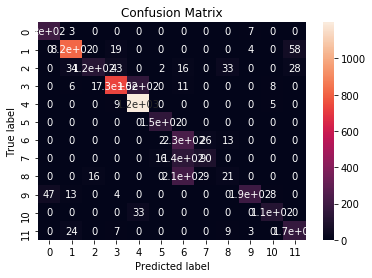

In [258]:
plot_model_performance(Ytest['Model1'], final_prediction)